In [1]:
import math
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from scipy.optimize import curve_fit

In [3]:
seaborn.set_context('notebook')
seaborn.set_style('whitegrid')

In [4]:
plt.rcParams['figure.figsize'] = [16, 8]

In [5]:
pop = pd.read_csv('../../ddf--datapoints--population_percentage--by--geo--year--coverage_type--income_bracket.csv')

In [6]:
pop = pop.set_index(['geo', 'year', 'coverage_type', 'income_bracket'])['population_percentage']

In [7]:
# maybe it's easier to make a function of x and y distance to y_max
def mval_at_point(x, y, x_y_max, y_max, maximum=10, minimum=0):
    # TODO: use y_max to modify d
    # print(x_y_max)
    x_d = (abs(x - x_y_max) / x_y_max) ** 2
    y_d = (abs(y - y_max) / y_max) ** 2
    
    if y_d == 0:
        return minimum
    
    d = maximum * (0.8 * x_d + 0.2 * y_d)
    
    d = int(d)
    
    if d <= minimum:
        return minimum
    if d > maximum:
        return maximum
    else:
        return d

In [8]:
def get_sample_at_point(x, arr, mval=None):
    y = arr[x]
    y_max = arr.max()
    x_y_max = np.where(arr == y_max)[0][0]
    if not mval:
        mval = mval_at_point(x, y, x_y_max, y_max)

    if x + mval + 1 > len(arr):
        pad = x + mval - len(arr) + 1 
        ending = np.zeros(pad)
    else:
        ending = np.array([])
    
    if x < mval:
        pad = mval - x
        beginning = np.zeros(pad)
    else:
        beginning = np.array([])
        
    res = np.concatenate([beginning, arr, ending])
        
    if len(beginning) > 0:
        return res[:(mval * 2 + 1)]
    else:
        return res[(x - mval):(x + mval + 1)]

In [9]:
def tricubic(x):
    y = np.ones_like(x)
    # idx = (x >= -1) & (x <= 1)
    max_d = x.max() - x.min()
    xmin = x.min()
    if max_d == 0:
        return y
    for idx, xv in enumerate(x):
        y[idx] = np.power(1.0 - np.power(np.abs(x[idx] - xmin), 3), 3)
    return y

In [10]:
def func(x, a, b):
    return a * x + b

In [11]:
def estimate(sample, weights, xpos):
    x = list(range(len(sample)))
    y = sample
    popt, pcov = curve_fit(func, x, y, sigma=weights)
    # print(popt)
    return popt[0] * xpos + popt[1]

In [18]:
def run(ser, maximum=10, minimum=1):
    res = []
    for i in range(len(ser)):
        # print(i, end=',')
        y = ser.values[i]
        y_max = ser.max()
        x_y_max = ser[ser == ser.max()].index[0]
    #     if x_y_max == i:
    #         res.append(ser.max())
    #         print()
    #         continue
        mval = mval_at_point(i, y, x_y_max, y_max, maximum=maximum, minimum=minimum)
        # print(mval)
        if mval == 0:
            res.append(y)
            continue
        sample = get_sample_at_point(i, ser, mval=mval)
        # print(sample)
        assert len(sample) == 2 * mval + 1, f"i={i}, size={len(sample)}, mval={mval}"
        weights = tricubic(sample)
        try:
            res.append(estimate(sample, weights, mval))
        except:
            print(i, sample, weights, mval)
            raise
            
    return pd.Series(res)

In [46]:
p1 = pop.loc['aus', 1981, 'n', :]

In [47]:
ser = p1.reset_index(drop=True)

In [48]:
ser.describe()

count    100.000000
mean       0.010000
std        0.024505
min        0.000000
25%        0.000000
50%        0.000000
75%        0.003304
max        0.106368
Name: population_percentage, dtype: float64

In [49]:
res = run(ser, 10, 1)

if ser.std() < 0.021:
    res = run(res, 8, 1)
    res = run(res, 8, 1)
    res = run(res, 5, 0)
    res = run(res, 5, 0)
else:
    res = run(res, 8, 0)
    res = run(res, 8, 0)
    res = run(res, 5, 0)
    res = run(res, 5, 0)
    
# res = run(res, 5, 0)
# res = run(res, 5, 0)
# res = run(res, 5, 0)
# res = run(res, 5, 0)

<AxesSubplot:>

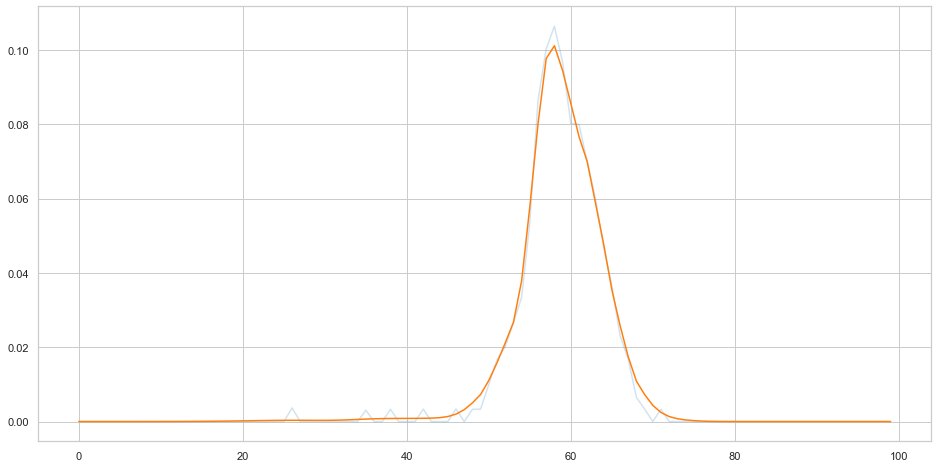

In [50]:
ser.plot(alpha=.2)
res.plot()

In [35]:
print(np.abs(ser - res).max())
print(res.sum())

0.00911054100546993
1.015501836658094


In [36]:
res1 = res / res.sum() 

<AxesSubplot:>

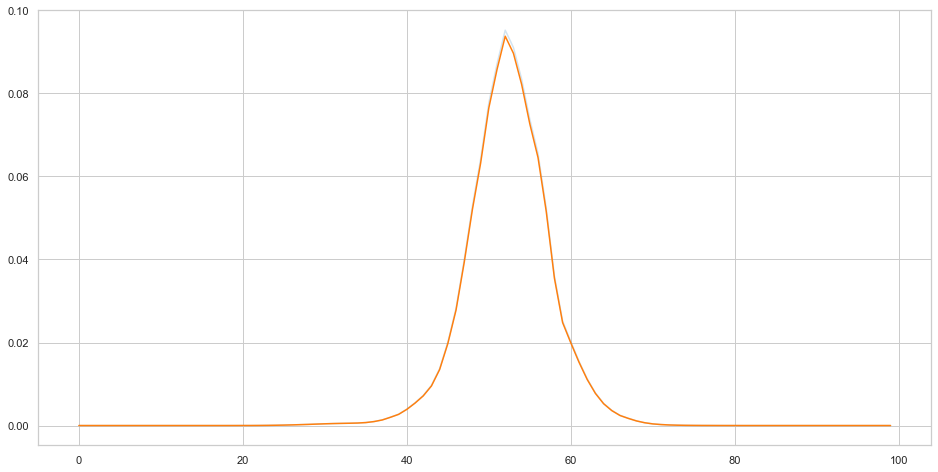

In [37]:
res.plot(alpha=.2)
res1.plot()

In [38]:
res1.sum()

1.0

In [51]:
pop2 = pd.read_csv('../../ddf--datapoints--population_percentage_smooth--by--geo--year--coverage_type--income_bracket.csv')

In [53]:
pop2 = pop2.set_index(['geo', 'year', 'coverage_type', 'income_bracket'])['population_percentage_smooth']

In [62]:
p1 = pop.loc['kor', 2012, 'n', :]
p2 = pop2.loc['kor', 2012, 'n', :]

<AxesSubplot:xlabel='geo,year,coverage_type,income_bracket'>

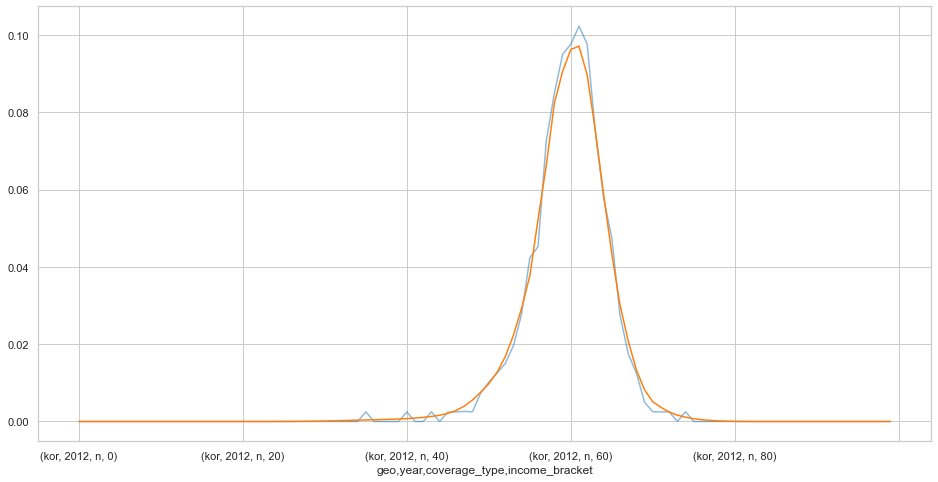

In [63]:
p1.plot(alpha=.5)
p2.plot()